In [ ]:
!pip3 install corus
!pip3 install pandas
!pip3 install scikit-learn

Скачиваем файл с данными сайта lenta.ru

In [ ]:
!wget https://github.com/yutkin/Lenta.Ru-News-Dataset/releases/download/v1.1/lenta-ru-news.csv.bz2

In [ ]:
!bzip2 -d lenta-ru-news.csv.bz2

In [ ]:
import pandas as pd
df_lenta = pd.read_csv('lenta-ru-news.csv', usecols=['text', 'topic'])
print('Записей в таблице:', df_lenta.shape[0])
df_lenta.head()

Записей в таблице: 800975


/tmp/ipykernel_43306/1410979440.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_lenta = pd.read_csv('lenta-ru-news.csv', usecols=['text', 'topic'])


,text,topic
0,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека
1,"Министерство народного просвещения, в виду про...",Библиотека
2,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",Библиотека
3,Фотограф-корреспондент Daily Mirror рассказыва...,Библиотека
4,"Лица, приехавшие в Варшаву из Люблина, передаю...",Библиотека


Выведем статистику по топикам

In [ ]:
stats=pd.DataFrame(df_lenta['topic'].value_counts())
stats

,count
topic,
Россия,160445
Мир,136621
Экономика,79528
Спорт,64413
Культура,53797
Бывший СССР,53402
Наука и техника,53136
Интернет и СМИ,44663
Из жизни,27605


In [ ]:
!pip3 install seaborn

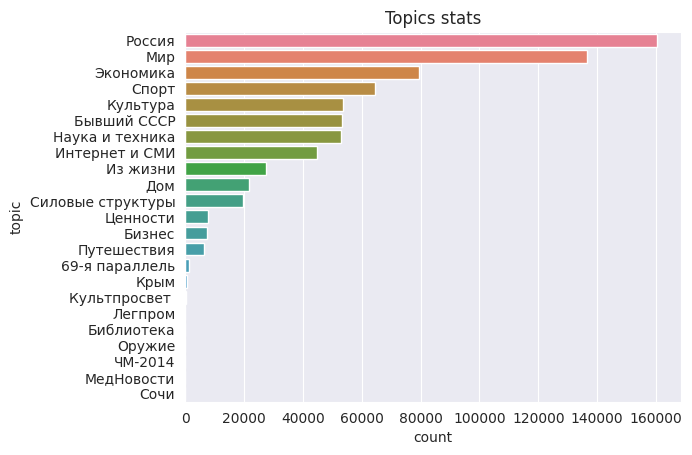

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.barplot(x='count', y='topic', hue='topic', data=stats)
plt.title('Topics stats')
plt.show()

Проблема заключается в том, что некоторые топики представлены малым количеством примеров. Для сбалансированной работы с датасетом выберем только 8 самых больших топиков и выровним количество примеров по каждому топику относительно меньшего

In [ ]:
df_lenta_clean = df_lenta.loc[df_lenta['topic'].isin(['Россия', 'Мир', 'Экономика', 'Спорт', 'Культура','Бывший СССР','Наука и техника', 'Интернет и СМИ'])]

resampling = df_lenta_clean.groupby('topic')
#class_size = 10000
class_size = resampling.size().min()
df_lenta_clean = pd.DataFrame(resampling.apply(lambda x: x.sample(class_size).reset_index(drop=True)))
#del df_lenta
stats=pd.DataFrame(df_lenta_clean['topic'].value_counts())
stats

,count
topic,
Бывший СССР,44663
Интернет и СМИ,44663
Культура,44663
Мир,44663
Наука и техника,44663
Россия,44663
Спорт,44663
Экономика,44663


In [ ]:
!pip3 install datasets evaluate sentence_transformers > None
!pip3 uninstall -y transformers accelerate
!pip3 install transformers accelerate

Found existing installation: transformers 4.41.2
Uninstalling transformers-4.41.2:
  Successfully uninstalled transformers-4.41.2
Found existing installation: accelerate 0.30.1
Uninstalling accelerate-0.30.1:
  Successfully uninstalled accelerate-0.30.1
  Using cached transformers-4.41.2-py3-none-any.whl.metadata (43 kB)
  Using cached accelerate-0.30.1-py3-none-any.whl.metadata (18 kB)
Using cached transformers-4.41.2-py3-none-any.whl (9.1 MB)
Using cached accelerate-0.30.1-py3-none-any.whl (302 kB)


Для обработки данных используем токенизатор нейронной сети rubert-tiny2

In [ ]:
import torch
from transformers import AutoTokenizer
from datasets import Dataset

tokenizer_config = {'pretrained_model_name_or_path':"cointegrated/rubert-tiny2",'max_len':2048}
tokenizer = AutoTokenizer.from_pretrained(**tokenizer_config)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=tokenizer.model_max_length)


Переименуем столбец topic в label и удалим пустые строки. Конвертируем данные из формата pandas в формат dataset. Разбиваем данные на train и test и кодируем столбец label.

In [ ]:
from datasets import Dataset
df_lenta_clean_l=df_lenta_clean.rename(columns={"topic": "label"})
df_lenta_clean_l = df_lenta_clean_l.dropna()
ds = Dataset.from_pandas(df_lenta_clean_l)
ds = ds.train_test_split(test_size=0.2)
ds = ds.class_encode_column("label")

Flattening the indices:   0%|          | 0/285840 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/285840 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/71461 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/71461 [00:00<?, ? examples/s]

In [ ]:
tokenized_datasets = ds.map(tokenize_function, batched=True)

Map:   0%|          | 0/285840 [00:00<?, ? examples/s]

Map:   0%|          | 0/71461 [00:00<?, ? examples/s]

Загружаем модель нейронной сети rubert-tiny2 для обучения

In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("cointegrated/rubert-tiny2", num_labels=8)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Настраиваем функцию расчета метрики f1

In [ ]:
import numpy as np
import evaluate
metric = evaluate.load("f1")


In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels,average="weighted")


In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test_trainer", eval_strategy="epoch")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Создаем объект trainer с нашей моделью, аргументами обучения, наборами тренировочных и тестовых данных и функцией оценки. И запускаем обучение.

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.340700,0.328472,0.903624
2,0.243800,0.347452,0.913305
3,0.165000,0.444251,0.912464


TrainOutput(global_step=107190, training_loss=0.2653275853607323, metrics={'train_runtime': 81378.2587, 'train_samples_per_second': 10.537, 'train_steps_per_second': 1.317, 'total_flos': 2.531390873665536e+16, 'train_loss': 0.2653275853607323, 'epoch': 3.0})

Ниже показаны результаты обучения, когда для каждого класса было выбрано по 10000 примеров, и когда мы уровняли количество примеров по минимальному классу. А также показаны для сравнения результаты обучения Tfidf+LogisticRegression.

In [ ]:
#Fine-tune
# 10000 samples 8 classes
#rubert-tiny2
#Epoch 	Training Loss 	 Validation Loss 	F1
#1 	    0.373000 	     0.385419 	       0.888981
#2 	    0.285700 	     0.427618 	       0.894159
#3 	    0.183000 	     0.492318 	       0.895980

#Fine-tune
#44663
#rubert-tiny2
#Epoch 	Training Loss 	Validation Loss 	F1
#1 	    0.340700 	    0.328472 	       0.903624
#2 	    0.243800 	    0.347452 	       0.913305
#3 	    0.165000 	    0.444251 	       0.912464

#Tfidf+LogisticRegression
# f1 0.88